In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle

# Import Libraries
import dlib
import glob
import cv2
import os
import sys
import time
# import pyautogui as pyg
# import shutil

from PIL import Image

import json

In [82]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

import dlib
from PIL import Image

import face_alignment
from skimage import io
import copy
import json
import time
import os
import pickle
import ffmpeg

from natsort import natsorted, ns

from scipy.signal import medfilt
from scipy.ndimage.filters import uniform_filter1d

import collections

In [3]:
# load face detector model
detector = dlib.simple_object_detector("Bentley_Th_Head_Detector_v2.svm")

In [116]:
# output = optimal_quantization(mat, True)  
def optimal_quantization(t2d_data, print_mode = False):
    
    t2d_data_cp = copy.deepcopy(t2d_data)  
    
    vector_data= np.reshape(t2d_data_cp, t2d_data_cp.shape[0]*t2d_data_cp.shape[1])
    # select only values above zero when calculating min/max to avoid padding - sm
    vector_data = vector_data[vector_data > 0]
    
    min_T=np.percentile(vector_data, 2.5)  #2.5 percentile point
#     max_T=np.percentile(vector_data, 97.5) #97.5 percentile point
    
    # try a higher max_T - sm
    max_T=np.percentile(vector_data, 100) #99.5 percentile point
#     max_T = 36

    t2d_data_cp[np.where(t2d_data_cp > max_T)]=max_T
    t2d_data_cp[np.where(t2d_data_cp < min_T)]=min_T

    opt_T=min_T
    count=0
    while True:
        count+=1
        mean_back=np.mean(t2d_data_cp[np.where(t2d_data_cp <= opt_T)])
        mean_obj=np.mean(t2d_data_cp[np.where(t2d_data_cp > opt_T)])
        if np.abs(opt_T - (mean_back+mean_obj)/2 )<0.005:
            break;
        else:
            opt_T=(mean_back+mean_obj)/2

    min_T=opt_T

    if print_mode:
        print("optimal thermal range is [%f, %f]"%(min_T,max_T))

    t2d_data_cp[np.where(t2d_data_cp < min_T)]=min_T

    quantized_t_img=np.zeros((t2d_data_cp.shape[0],t2d_data_cp.shape[1]), np.uint8)

    for i in range(0, t2d_data_cp.shape[0]):
        for j in range(0, t2d_data_cp.shape[1]):
            quantized_t_img[i,j]=255*((t2d_data_cp[i,j]-min_T)/(max_T-min_T))

    return quantized_t_img 

In [117]:
def opt_quant_list(image_list, print_mode=False):
    new_image_list = []
    for i, img in enumerate(image_list):
        new_image = optimal_quantization(img, print_mode = print_mode)
        new_image_list.append(new_image)
    return new_image_list 

## Load all thermal images

In [5]:
thr_sel_dict = {'03': [1482,2082],
                '04': [12758,13358],
                '05': [16067,16667],
                '06': [20278,20878],
                '07': [12179,12779],
                '08': [13098,13698],
                '09': [14876,15476],
                '10': [16901,17501],
                '13': [2063,2663],
                '14': [20441,21041],
                '15': [4051,4651],
                '16': [3418,4018],
                '17': [2355,2955],
                '22': [7548,8148],
                '24': [10086,10686],
                '25': [1819,2419],
                '26': [352,952],
                '27': [8767,9367]}

In [6]:
p_list_all = list(thr_sel_dict.keys())
print(p_list_all)

['03', '04', '05', '06', '07', '08', '09', '10', '13', '14', '15', '16', '17', '22', '24', '25', '26', '27']


In [8]:
def thr_load(img_dir, first_img=0, last_img=None, interval=1):
    # create list of npy images in directory
    filenames = [f for f in os.listdir(img_dir) if f.split('.')[1] == 'npy']
    
    filenames = natsorted(filenames, alg=ns.IGNORECASE)
        
    img_list = []
        
    # selecting images to analyse
    filenames=filenames[first_img:last_img:interval]
        
    for filename in filenames:
        img = np.load(img_dir + filename)
        img_list.append(img)    
        
    return filenames, img_list

In [58]:
thr_dat_dict = collections.defaultdict(dict)
st = time.time()

for p in p_list_all:

    print('p:', p)
    img_dir = '/Volumes/Ashur DT2/steven/P'+p+'/FLIR_HiRes/npy/'
    first_img = thr_sel_dict[p][0]
    last_img = thr_sel_dict[p][1]
    filenames, img_list = thr_load(img_dir, first_img=first_img, last_img=last_img, interval=1)
    thr_dat_dict[p]['imgs'] = img_list
    thr_dat_dict[p]['fnames'] = filenames
    
print('Time taken: {:.2f} seconds'.format(time.time() - st))

p: 03
p: 04
p: 05
p: 06
p: 07
p: 08
p: 09
p: 10
p: 13
p: 14
p: 15
p: 16
p: 17
p: 22
p: 24
p: 25
p: 26
p: 27
Time taken: 83.66 seconds


## select only data with accurate landmarks

In [62]:
# find the indices of filesnames where the transform looked good
def multi_range(filenames_list, range_list):
    file_no = [int(x.split('.')[0].split('_')[1]) for x in filenames_list]
    sel_nb = []
    for limits in range_list:
        sel_nb += [x for x in file_no if limits[0] <= x <= limits[1]]
        
    sel_idx = [i for i, j in enumerate(file_no) if j in sel_nb]
    return sel_idx

In [65]:
# dictionary of good filenames where transferred landmarks looked good
acc_data_dict = {'03':[(1482,2081)],
                 '04':[(12758,13213)],
                 '05':[(16067,16074),(16147,16155),(16188,16352),(16407,16410),
                       (16572,16586)],
                 '06':[(20278,20441),(20486,20548),(20575,20732),(20781,20853),
                       (20862,20877)],
                 '07':[(12179,12250),(12272,12295),(12306,12496),(12516,12714),
                       (12726,12766)],
                 '08':[(13116,13361),(13420,13497),(13542,13559)],
                 '09':[(14876,14934),(14957,15097),(15149,15273),(15368,15475)],
                 '10':[(16901,17500)],
                 '13':[(2063,2193),(2198,2255),(2259,2268),(2272,2493),(2521,2539),
                       (2543,2560),(2564,2662)],
                 '14':[(20441,21040)],
                 '15':[(4051,4650)],
                 '16':[(3571,3902),(3984,3989)],
                 '17':[(2355,2954)],
                 '22':[(7548,8147)],
                 '24':[(10086,10100),(10123,10201),(10224,10290),(10310,10312),
                       (10336,10685)],
                 '25':[(1819,2418)],
                 '26':[(352,951)],
                 '27':[(8767,9088),(9126,9268),(9334,9366)],
                }

In [68]:
thr_dat_acc_idxs = collections.defaultdict(dict)
for p in p_list_all:
    thr_dat_acc_idxs[p] = multi_range(thr_dat_dict[p]['fnames'], acc_data_dict[p])

In [81]:
# select imgs and fnames for each p based on good index lists
thr_dat_dict_sel = collections.defaultdict(dict)
for p in p_list_all:
    thr_dat_dict_sel[p]['imgs'] = [thr_dat_dict[p]['imgs'][i] for i in thr_dat_acc_idxs[p]]
    thr_dat_dict_sel[p]['fnames'] = [thr_dat_dict[p]['fnames'][i] for i in thr_dat_acc_idxs[p]]

## Load all transferred landmarks

In [139]:
def lmark_load(lmark_dir):
    filenames = [f for f in os.listdir(lmark_dir) if f.split('.')[1] == 'pickle']
    filenames.sort()
    # Load landmarks
    lmark_dict = collections.defaultdict(dict)
    
    for filename in filenames:
        p = filename[1:3]
        with open(lmark_dir + filename, 'rb') as handle:
            landmarks = pickle.load(handle)
        lmark_dict[p] = landmarks
        
    return lmark_dict

In [140]:
lmark_dir = '/Volumes/Ashur DT2/steven/good_169_pickles/'
lmark_dict = lmark_load(lmark_dir)

## select good landmarks as for images and fnames

In [141]:
# select landmarks for each p based on good index lists
for p in p_list_all:
    thr_dat_dict_sel[p]['lmarks'] = [lmark_dict[p][i] for i in thr_dat_acc_idxs[p]]

In [142]:
# create a key with just the p name in in for later code
for p in p_list_all:
    thr_dat_dict_sel[p]['pname'] = [p]*len(thr_dat_dict_sel[p]['lmarks'])

## flatten image and landmark lists

In [143]:
img_list_i1_flat = [thr_dat_dict_sel[x]['imgs'] for x in p_list_all]
img_list_i1_flat = [item for sublist in img_list_i1_flat for item in sublist]

filenames_list_i1_flat = [thr_dat_dict_sel[x]['fnames'] for x in p_list_all]
filenames_list_i1_flat = [item for sublist in filenames_list_i1_flat for item in sublist]

pnames_list_i1_flat = [thr_dat_dict_sel[x]['pname'] for x in p_list_all]
pnames_list_i1_flat = [item for sublist in pnames_list_i1_flat for item in sublist]

trans_lmark_list = [thr_dat_dict_sel[x]['lmarks'] for x in p_list_all]
trans_lmark_list = [item for sublist in trans_lmark_list for item in sublist]

# squeeze to remove extra dimensions
trans_lmark_list = [np.squeeze(lmarks) for lmarks in trans_lmark_list]

In [144]:
print(len(img_list_i1_flat))
print(len(trans_lmark_list))

9140
9140


## check on some images

In [145]:
def simple_scale(array):
    return (((array - array.min()) / (array.max() - array.min()))*255).astype('uint8')

In [146]:
def vis_pred(img_list, first_img, nrows, ncols):
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols+8, nrows+8)) # create figure
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]); # turn off all axes ticks
    idx_plt = 0
    for row in range(nrows):
        for col in range(ncols):
            img_np = img_list[idx_plt+first_img].copy()
            # convert to readable image
            img = simple_scale(img_np)
            
            detections = detector(img)
            # Loop for each detection.
            for detection in (detections):    

                x1 = int(detection.left())
                y1 =  int(detection.top())
                x2 =  int(detection.right())
                y2 =  int(detection.bottom())

                # Draw the bounding box
                cv2.rectangle(img,(x1,y1),(x2,y2),(255,255,0),2)
                        
            
#             name_text = filenames_list[idx_plt+first_img].split('.')[0][10:]
            if nrows == 1 or ncols == 1:
                ax[idx_plt].imshow(img)
#                 ax[idx_plt].set_title(name_text)
            else:
                ax[row][col].imshow(img)
#                 ax[row][col].set_title(name_text)
            idx_plt+= 1
            
    plt.tight_layout()
    plt.show()

In [118]:
# Optimal quantisation
start_time = time.time()
img_list_i1_oq = opt_quant_list(img_list_i1_flat)
print("runtime:", time.time() - start_time)

runtime: 847.5582218170166


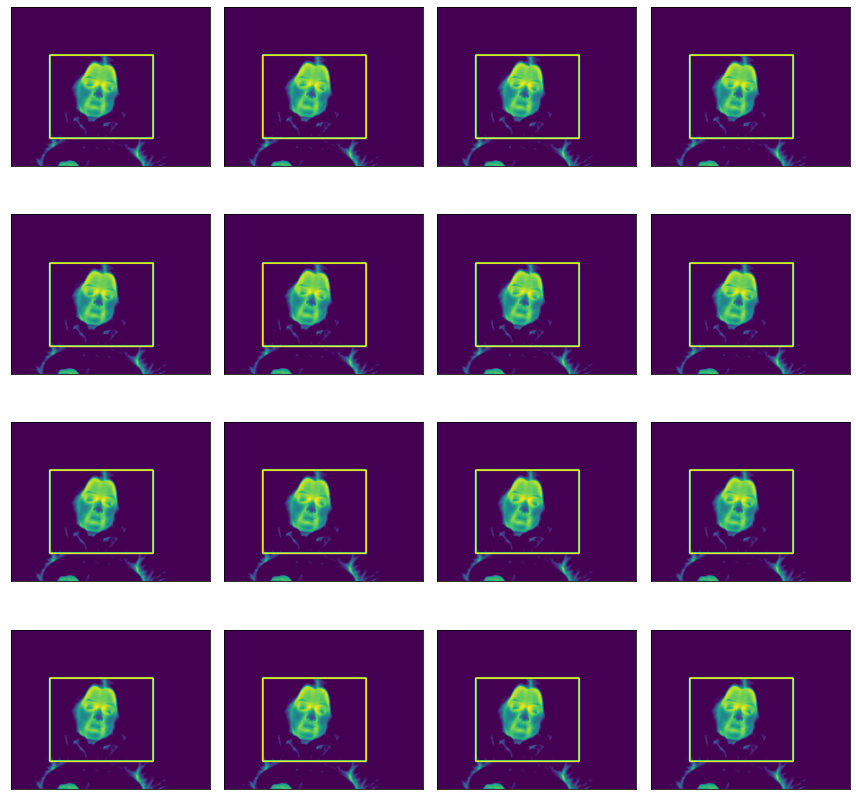

In [121]:
vis_pred(img_list_i1_oq, first_img=1000, nrows=4, ncols=4)

## Detect for all faces and save

In [122]:
def face_detect(image_list, detector):
    detect_img_list = []
    detect_rect_list = []
    detect_indices = []
    idx = 0
    for img_np in image_list:
        try:
            img = simple_scale(img_np)
            detections = detector(img)
            detect_img_list.append(img)
            detect_rect_list.append(detections)
            detect_indices.append(idx)
            idx += 1
        except:
            pass
    return detect_img_list, detect_rect_list, detect_indices

In [123]:
st = time.time()
detect_img_list, detect_rect_list, detect_indices = face_detect(img_list_i1_oq, detector)
print('Detect Completed, Total Time taken: {:.2f} seconds'.format(time.time() - st))

Detect Completed, Total Time taken: 65.32 seconds


In [124]:
print(len(img_list_i1_oq))
print(len(detect_img_list))
print(len(detect_rect_list))

9140
9140
9140


In [125]:
def valid_detect_idx(detect_rect_list):
    # only return indices on detection list where 1 face detected
    valid_detect_indices = []
    count = 0
    for i, rect in enumerate(detect_rect_list):
        if len(rect) == 1:
            valid_detect_indices.append(i)
        else:
            print(i)
            count += 1
    print(count)
    return valid_detect_indices    

In [126]:
valid_detect_indices = valid_detect_idx(detect_rect_list)

0


In [127]:
print(len(valid_detect_indices))

9140


## Need to put in code from sciebo to only keep valid indices

In [128]:
def gen_valid_detect_lists(valid_detect_indices, target_list):
    valid_list = [target_list[i] for i in valid_detect_indices]
    return valid_list

In [129]:
valid_rect_list = gen_valid_detect_lists(valid_detect_indices, detect_rect_list)
valid_img_list = gen_valid_detect_lists(valid_detect_indices, detect_img_list)

In [130]:
valid_fname_list = gen_valid_detect_lists(valid_detect_indices, filenames_list_i1_flat)
valid_pname_list = gen_valid_detect_lists(valid_detect_indices, pnames_list_i1_flat)

In [131]:
print(len(valid_img_list))
print(len(valid_fname_list))
print(len(valid_pname_list))

9140
9140
9140


In [132]:
def plot_pred_bbox(img_list, rect_list, img_no):
    img = img_list[img_no].copy()
    for detection in (rect_list[img_no]):
        print(detection)
        x1 = int(detection.left())
        y1 =  int(detection.top())
        x2 =  int(detection.right())
        y2 =  int(detection.bottom())

        # Draw the bounding box
        cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0),2)
        plt.imshow(img)
        plt.show()

[(95, 45) (261, 178)]


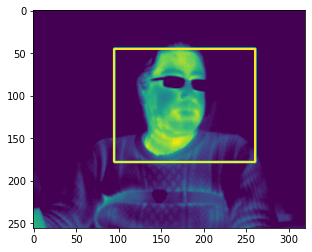

In [133]:
plot_pred_bbox(valid_img_list, valid_rect_list, 2033)

In [147]:
len(trans_lmark_list)

9140

In [148]:
# keep only lmarks where boxes detected
valid_landmarks_list = gen_valid_detect_lists(valid_detect_indices, trans_lmark_list)

In [149]:
print(len(valid_landmarks_list))
print(valid_landmarks_list[0].shape)

9140
(68, 2)


## Check landmarks

In [150]:
def check_lmarks(img_list, landmarks_list, first_img, nrows, ncols):
    '''plot landmarks on images given a list of both and first index on list
     to plot together with number of rows and columns'''
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols+10, nrows+10)) # create figure
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]); # turn off all axes ticks
    idx_plt = 0
    for row in range(nrows):
        for col in range(ncols):
            img = img_list[idx_plt+first_img].copy()
            landmark_tuples = landmarks_list[idx_plt+first_img]
            for n in range(0,68):
                try:
                    x=int(landmark_tuples[n][0])
                    y=int(landmark_tuples[n][1])
                    # print(x,y)
                    cv2.circle(img, (x, y), 1, (255, 255, 255), -1)
                except:
                    pass
                
            # cv2.circle(img, (10, 10), 1, (255, 255, 255), 10)
            if nrows == 1 or ncols == 1:
                ax[idx_plt].imshow(img)
            else:
                ax[row][col].imshow(img)
            idx_plt+= 1
            
    plt.tight_layout()
    plt.show()

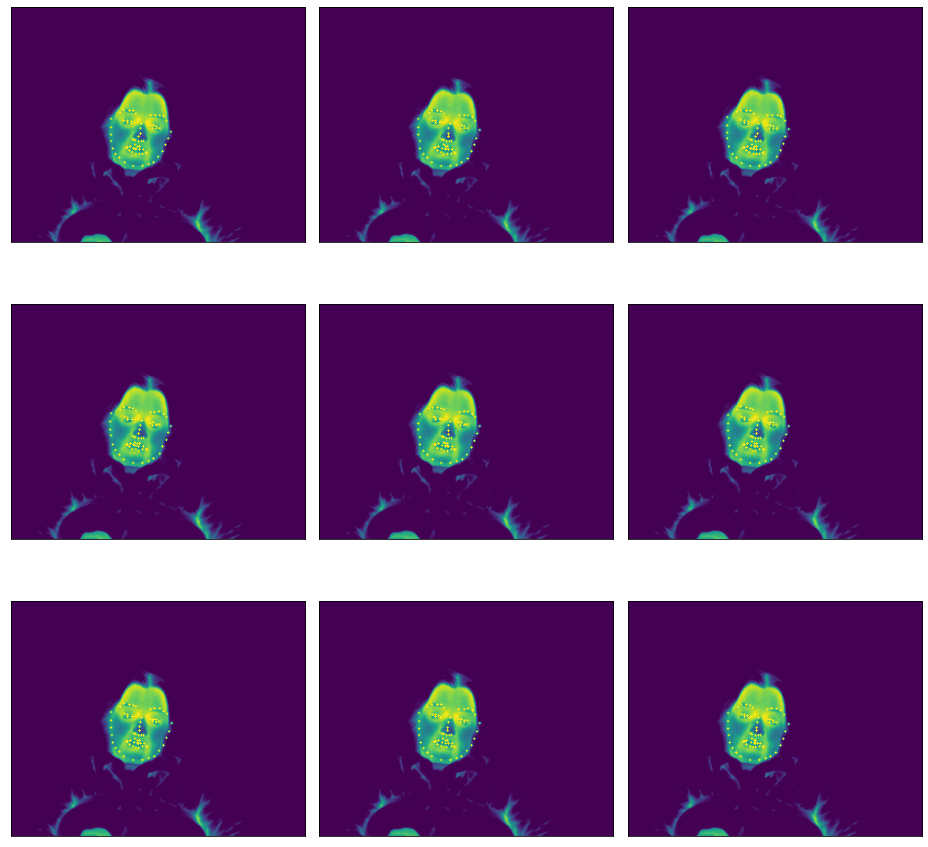

In [153]:
check_lmarks(valid_img_list, valid_landmarks_list, 1000, 3, 3)

# Crop images and landmarks using predicted boxes

In [154]:
def crop_landmarks(landmarks, bbox):
    try:
        for box in (bbox):
            x1 = int(box.left())
            y1 =  int(box.top())
    #     x1 = bbox[0][1]
    #     y1 = bbox[0][0]
    except:
        pass
    new_landmarks = []
    try:
        for lm in landmarks:
            lmx_shift = lm[0] - x1
            lmy_shift = lm[1] - y1
            new_landmarks.append((lmx_shift,lmy_shift))
    except:
        pass
    return new_landmarks

In [155]:
def crop_landmarks_list(landmarks_list, bbox_list):
    new_landmarks_list = []
    for i, lms in enumerate(landmarks_list):
        bbox = bbox_list[i]
        new_landmarks = crop_landmarks(lms, bbox)
        new_landmarks_list.append(new_landmarks)
    return new_landmarks_list    

In [156]:
landmarks_crop_list = crop_landmarks_list(valid_landmarks_list, valid_rect_list)

In [157]:
def crop_image(image, bbox):
    try:
        for box in (bbox):
            x1 = int(box.left())
            y1 = int(box.top())
            x2 =  int(box.right())
            y2 =  int(box.bottom())

        image = image[y1:y2,x1:x2] 
    except:
        pass
    return image

In [158]:
def crop_image_list(image_list, bbox_list):
    new_image_list = []
    for i, img in enumerate(image_list):
        bbox = bbox_list[i]
        image_crop = crop_image(img, bbox)
        new_image_list.append(image_crop)
    return new_image_list    

In [159]:
valid_img_crop_list = crop_image_list(valid_img_list, detect_rect_list)

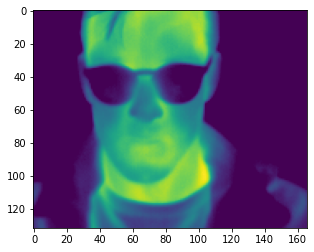

In [160]:
# check an image
image_crop = crop_image(valid_img_list[6435], detect_rect_list[6435])
plt.imshow(image_crop)
plt.show()

In [161]:
def plot_crop_landmarks(img_list, landmarks_list, img_no):
    img = img_list[img_no].copy()
    landmark_tuples = landmarks_list[img_no]
    for n in range(0,68):
        try:
            x=int(landmark_tuples[n][0])
            y=int(landmark_tuples[n][1])
            cv2.circle(img, (x, y), 1, (255, 0, 0), 2)
        except:
            pass
    plt.imshow(img)
    plt.show()

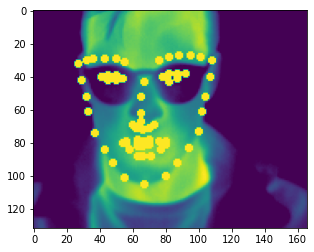

In [162]:
plot_crop_landmarks(valid_img_crop_list, landmarks_crop_list, 6435)

In [163]:
def resize_image(image, new_size=(128, 128)):
    img_resize = Image.fromarray(image)
    img_resize = img_resize.resize(new_size, Image.ANTIALIAS)
    img_resize_np = np.array(img_resize)
    return img_resize_np

In [164]:
def resize_image_list(image_list, new_size=(128, 128)):
    new_image_list = []
    for i, img in enumerate(image_list):
        new_image = resize_image(img, new_size=new_size)
        new_image_list.append(new_image)
    return new_image_list 

In [165]:
valid_img_resize_list = resize_image_list(valid_img_crop_list, new_size=(128, 128))

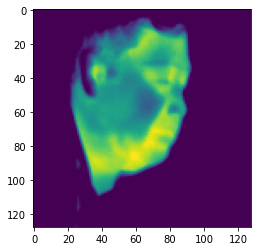

In [166]:
plt.imshow(valid_img_resize_list[7033])
plt.show()

In [167]:
# re-size landmark locations to 128x128 equivalent
def resize_landmarks(landmarks, orig_dim=(446,446), new_dim=(128,128)):
    scale_y = new_dim[0]/orig_dim[0]
    scale_x = new_dim[1]/orig_dim[1]
    new_landmarks = []
    for lm in landmarks:
        lmx_shift = int(lm[0] * scale_x)
        lmy_shift = int(lm[1] * scale_y)
        new_landmarks.append((lmx_shift,lmy_shift))
    return new_landmarks

In [168]:
def resize_landmarks_list(landmarks_list, valid_img_crop_list, new_dim=(128,128)):
    # resize landmark coords from original image size to new target size
    new_landmark_list = []
    good_indices = []
    for i, lms in enumerate(landmarks_list):
        # original dimensions from shape of original image
        orig_dim = (valid_img_crop_list[i].shape[:2])
        try:
            lms_resize = resize_landmarks(landmarks_list[i], orig_dim=orig_dim, new_dim=new_dim)
            new_landmark_list.append(lms_resize)
            good_indices.append(i)
        except:
            pass
    return new_landmark_list, good_indices

In [169]:
valid_landmarks_resize_list, good_indices = resize_landmarks_list(landmarks_crop_list, valid_img_crop_list, new_dim=(128,128))

In [170]:
valid_img_resize_list = [valid_img_resize_list[i] for i in good_indices]

In [171]:
print([i for i in range(9000) if i not in good_indices])

[1242, 1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256]


In [172]:
valid_pname_list = [valid_pname_list[i] for i in good_indices]

In [173]:
print(len(valid_landmarks_resize_list))
print(len(valid_img_resize_list))
print(len(valid_pname_list))

9125
9125
9125


In [174]:
len([x for x in valid_pname_list if x == '05'])

186

In [175]:
def plot_valid_resize_landmarks(img_list, landmarks_list, first_img=0, nrows=4, ncols=4):
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols+8, nrows+8)) # create figure
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]); # turn off all axes ticks
    idx_plt = 0
    for row in range(nrows):
        for col in range(ncols):
            img = img_list[idx_plt+first_img].copy()
            img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
            lms = landmarks_list[idx_plt+first_img]
            for n in range(0,68):
                x=int(lms[n][0])
                y=int(lms[n][1])
                cv2.circle(img, (x, y), 1, (255, 0, 0), 1)
#             name_text = filenames_list[idx_plt+first_img].split('.')[0][10:]
            if nrows == 1 or ncols == 1:
                ax[idx_plt].imshow(img)
#                 ax[idx_plt].set_title(name_text)
            else:
                ax[row][col].imshow(img)
#                 ax[row][col].set_title(name_text)
            idx_plt+= 1
            
    plt.tight_layout()
    plt.show()    

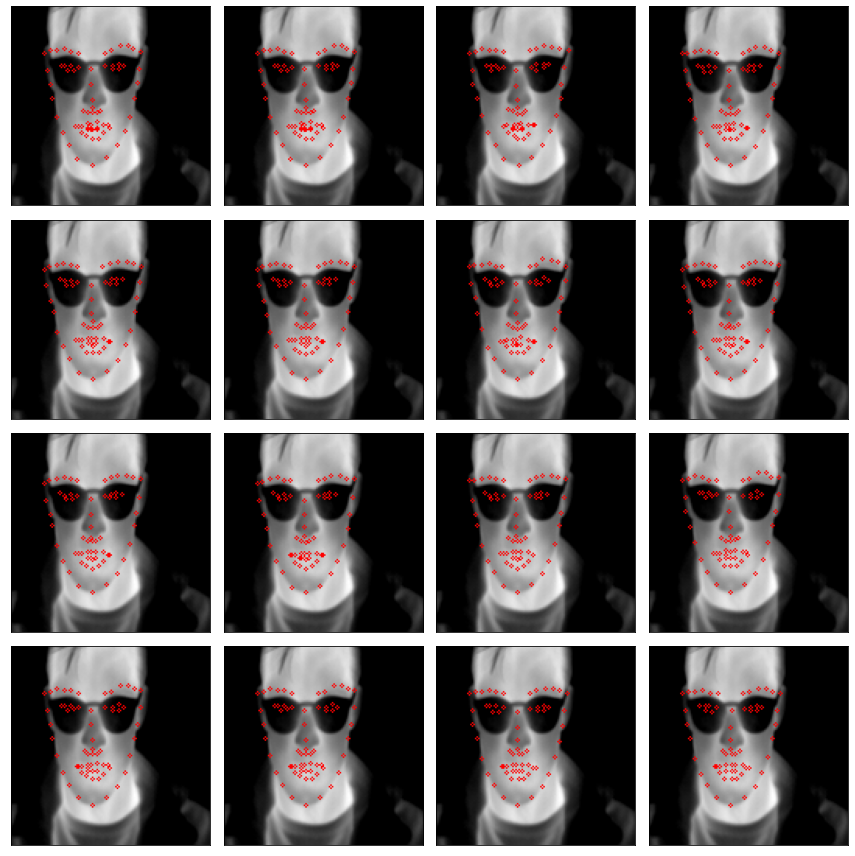

In [176]:
plot_valid_resize_landmarks(valid_img_resize_list, valid_landmarks_resize_list, first_img=6435, nrows=4, ncols=4)

## Plot for report

In [177]:
def vis_resize_report(img, img_crop, img_resize, bbox, lm_resize):
    fig, ax = plt.subplots(ncols=3, figsize=(16, 5))
    
    img_c = img.copy()
    img_crop_c = img_crop.copy()
    img_resize_c = img_resize.copy()
            
    img_c = np.repeat(img_c[:, :, np.newaxis], 3, axis=2)
    img_crop_c = np.repeat(img_crop_c[:, :, np.newaxis], 3, axis=2)
    img_resize_c = np.repeat(img_resize_c[:, :, np.newaxis], 3, axis=2)
    
    for detection in (bbox):
        x1 =  int(detection.left())
        y1 =  int(detection.top())
        x2 =  int(detection.right())
        y2 =  int(detection.bottom())

        # Draw the bounding box
        cv2.rectangle(img_c,(x1,y1),(x2,y2),(0,255,0),2)
            
    for n in range(0,68):
            x=lm_resize[n][0]
            y=lm_resize[n][1]
            cv2.circle(img_resize_c, (x, y), 1, (255, 0, 0), 1)
    
    ax[0].imshow(img_c, cmap=plt.get_cmap('gray'))
    ax[1].imshow(img_crop_c, cmap=plt.get_cmap('gray'))
    ax[2].imshow(img_resize_c, cmap=plt.get_cmap('gray'))
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')

    ax[0].set_title("a)", fontsize = 20)
    ax[1].set_title("b)", fontsize = 20)
    ax[2].set_title("c)", fontsize = 20)
                
    plt.tight_layout()
#     plot_name = 'resize_example.png'
#     plt.savefig(plot_name)

    plt.show()

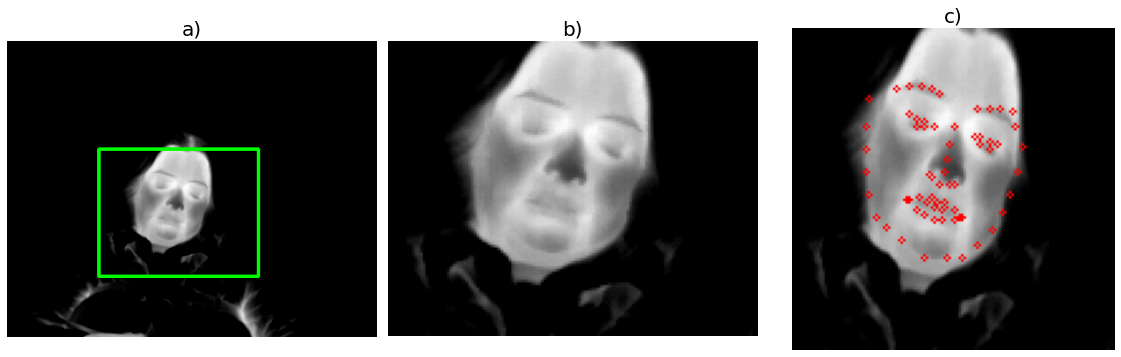

In [178]:
vis_resize_report(img_list_i1_oq[600], 
                  valid_img_crop_list[600], 
                  valid_img_resize_list[600],
                  valid_rect_list[600],
                  valid_landmarks_resize_list[600])

## save resize images and landmarks - train, val, test

In [193]:
train_p = ['03', '05', '06', '08', '10', '13', '15', '16', '22', '25', '26', '27']
val_p = ['04', '07', '24']
test_p = ['09', '14', '17']

train_idx = [i for i, x in enumerate(valid_pname_list) if x in train_p]
val_idx = [i for i, x in enumerate(valid_pname_list) if x in val_p]
test_idx = [i for i, x in enumerate(valid_pname_list) if x in test_p]

print('len train:', len(train_idx))
print('len val:', len(val_idx))
print('len test:', len(test_idx))

len train: 5995
len val: 1497
len test: 1633


In [194]:
train_imgs = [valid_img_resize_list[i] for i in train_idx]
val_imgs = [valid_img_resize_list[i] for i in val_idx]
test_imgs = [valid_img_resize_list[i] for i in test_idx]

train_lmarks = [valid_landmarks_resize_list[i] for i in train_idx]
val_lmarks = [valid_landmarks_resize_list[i] for i in val_idx]
test_lmarks = [valid_landmarks_resize_list[i] for i in test_idx]

print('len train:', len(train_imgs), len(train_lmarks))
print('len val:', len(val_imgs), len(val_lmarks))
print('len test:', len(test_imgs), len(test_lmarks))

len train: 5995 5995
len val: 1497 1497
len test: 1633 1633


In [195]:
save_dir = '/Volumes/Ashur DT2/steven/nn_training_data/v05/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save resized landmarks
with open(save_dir + 'resized_lmarks_v05.pickle', 'wb') as handle:
    pickle.dump(valid_landmarks_resize_list, handle)
    
with open(save_dir + 'resized_lmarks_train_v05.pickle', 'wb') as handle:
    pickle.dump(train_lmarks, handle)
    
with open(save_dir + 'resized_lmarks_val_v05.pickle', 'wb') as handle:
    pickle.dump(val_lmarks, handle)
    
with open(save_dir + 'resized_lmarks_test_v05.pickle', 'wb') as handle:
    pickle.dump(test_lmarks, handle)
    
# Save resized images
with open(save_dir + 'resized_imgs_v05.pickle', 'wb') as handle:
    pickle.dump(valid_img_resize_list, handle)
    
with open(save_dir + 'resized_imgs_train_v05.pickle', 'wb') as handle:
    pickle.dump(train_imgs, handle)
    
with open(save_dir + 'resized_imgs_val_v05.pickle', 'wb') as handle:
    pickle.dump(val_imgs, handle)
    
with open(save_dir + 'resized_imgs_test_v05.pickle', 'wb') as handle:
    pickle.dump(test_imgs, handle)

## read back and check data

In [196]:
# reload
with open(save_dir + 'resized_lmarks_train_v05.pickle', 'rb') as handle:
    train_lmarks_read = pickle.load(handle)
    
with open(save_dir + 'resized_imgs_train_v05.pickle', 'rb') as handle:
    train_imgs_read = pickle.load(handle)

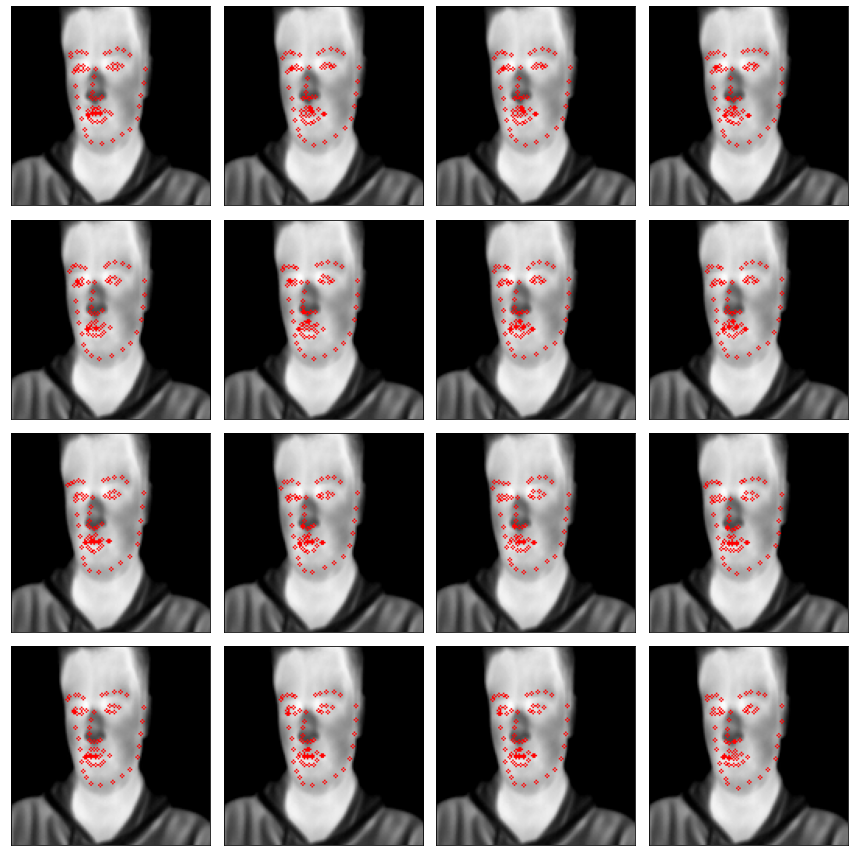

In [199]:
plot_valid_resize_landmarks(train_imgs_read, train_lmarks_read, first_img=5900, nrows=4, ncols=4)